# Text Wrangling and Regex

Working with text: applying string methods and regular expressions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import pandas as pd



# Real World Case Study: Restaurant Data

In this example, we will show how regexes can allow us to track quantitative data across categories defined by the appearance of various text fields.

In this example we'll see how the presence of certain keywords can affect quantitative data:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?**
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

In [53]:
# read data frame
df=pd.read_csv('sets/pandas 11/violations.csv')
df=df.rename(columns={'business_id':'bid','description':'desc'})
df.head()

bid      date  \
0   19  20171211   
1   19  20171211   
2   19  20160513   
3   19  20160513   
4   19  20160513   

                                                                                                   desc  
0                             Inadequate food safety knowledge or lack of certified food safety manager  
1                                                      Unapproved or unmaintained equipment or utensils  
2            Unapproved or unmaintained equipment or utensils  [ date violation corrected: 12/11/2017 ]  
3                Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/11/2017 ]  
4  Food safety certificate or food handler card not available  [ date violation corrected: 12/11/2017 ]

In [54]:
# Set pandas to display full columns without truncation
pd.set_option('display.max_colwidth', None)  # None removes the limit, display full column width

# Optionally, set maximum number of rows or columns displayed (useful for larger DataFrames)
pd.set_option('display.max_rows', None)      # None displays all rows
pd.set_option('display.max_columns', None)   # None displays all columns

In [55]:
# Now read full description without truncation
df['desc']

0                                                  Inadequate food safety knowledge or lack of certified food safety manager
1                                                                           Unapproved or unmaintained equipment or utensils
2                                 Unapproved or unmaintained equipment or utensils  [ date violation corrected: 12/11/2017 ]
3                                     Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/11/2017 ]
4                       Food safety certificate or food handler card not available  [ date violation corrected: 12/11/2017 ]
5                                                                                                      Improper food storage
6                                      Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/1/2017 ]
7                                      Unclean or degraded floors walls or ceilings  [ date violation corrected: 10/5/2016 ]


In [56]:
counts=df['desc'].value_counts()
counts

Unclean or degraded floors walls or ceilings                                                                           999
Unapproved or unmaintained equipment or utensils                                                                       659
Inadequately cleaned or sanitized food contact surfaces                                                                493
Improper food storage                                                                                                  476
Inadequate and inaccessible handwashing facilities                                                                     467
Moderate risk food holding temperature                                                                                 452
Wiping cloths not clean or properly stored or inadequate sanitizer                                                     418
Moderate risk vermin infestation                                                                                       374
Unclean nonfood 

In [57]:
#counts shape
counts.shape

(14253,)

In [58]:
# There is a lot of information under the description field, do we need to clean this text data?
# That's a lot of different descriptions!! Can we **canonicalize** at all? Let's explore two sets of 10 rows.
# Use regular expressions to cut out the extra info in square braces.
# Code Here
df['clean_desc']=df['desc'].str.replace(r"\[.*]","",regex=True)
df['clean_desc']=df['clean_desc'].str.strip()
df['clean_desc']=df['clean_desc'].str.lower()
df.head()

bid      date  \
0   19  20171211   
1   19  20171211   
2   19  20160513   
3   19  20160513   
4   19  20160513   

                                                                                                   desc  \
0                             Inadequate food safety knowledge or lack of certified food safety manager   
1                                                      Unapproved or unmaintained equipment or utensils   
2            Unapproved or unmaintained equipment or utensils  [ date violation corrected: 12/11/2017 ]   
3                Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/11/2017 ]   
4  Food safety certificate or food handler card not available  [ date violation corrected: 12/11/2017 ]   

                                                                  clean_desc  
0  inadequate food safety knowledge or lack of certified food safety manager  
1                           unapproved or unmaintained equipment or utensils  
2                           unapproved or unmaintained equipment or utensils  
3                               unclean or degraded floors walls or ceilings  
4                 food safety certificate or food handler card not available

In [59]:
# count unique description again, note canonicalizing definitely helped
df['clean_desc'].value_counts().shape

(68,)

In [60]:
df['clean_desc'].value_counts().head()

unclean or degraded floors walls or ceilings               3507
moderate risk food holding temperature                     2542
inadequate and inaccessible handwashing facilities         2529
unapproved or unmaintained equipment or utensils           2382
inadequately cleaned or sanitized food contact surfaces    2301
Name: clean_desc, dtype: int64

Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?**
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

Below, we use regular expressions and `df.assign()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html?highlight=assign#pandas.DataFrame.assign)) to **method chain** our creation of new boolean features, one per keyword.

In [61]:
ratings = (df
.assign(is_unclean=df['clean_desc'].str.contains('clean|sanit'))
.assign(is_high_risk=df['clean_desc'].str.contains('high risk'))
.assign(is_vermin=df['clean_desc'].str.contains('vermin'))
.assign(is_surface=df['clean_desc'].str.contains('wall|surface|floor|ceiling'))
.assign(is_human=df['clean_desc'].str.contains('hand|glove|hair|nail'))
.assign(is_permit=df['clean_desc'].str.contains('permit|certif'))                 
)
ratings.head()

bid      date  \
0   19  20171211   
1   19  20171211   
2   19  20160513   
3   19  20160513   
4   19  20160513   

                                                                                                   desc  \
0                             Inadequate food safety knowledge or lack of certified food safety manager   
1                                                      Unapproved or unmaintained equipment or utensils   
2            Unapproved or unmaintained equipment or utensils  [ date violation corrected: 12/11/2017 ]   
3                Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/11/2017 ]   
4  Food safety certificate or food handler card not available  [ date violation corrected: 12/11/2017 ]   

                                                                  clean_desc  \
0  inadequate food safety knowledge or lack of certified food safety manager   
1                           unapproved or unmaintained equipment or utensils   
2                           unapproved or unmaintained equipment or utensils   
3                               unclean or degraded floors walls or ceilings   
4                 food safety certificate or food handler card not available   

   is_unclean  is_high_risk  is_vermin  is_surface  is_human  is_permit  
0       False         False      False       False     False       True  
1       False         False      False       False     False      False  
2       False         False      False       False     False      False  
3        True         False      False        True     False      False  
4       False         False      False       False      True       True


### EDA

That's the end of our text wrangling. Now let's do some more analysis to analyze restaurant health as a function of the number of violation keywords.

To do so we'll first group so that our **granularity** is one inspection for a business on particular date. This effectively counts the number of violations by keyword for a given inspection.

In [62]:
# Code Here
x=ratings.groupby(['bid','date']).agg({
    'is_unclean':'sum',
    'is_high_risk':'sum',
    'is_vermin':'sum',
    'is_surface':'sum',
    'is_human':'sum',
    'is_permit':'sum',
}).reset_index()
x[x['bid']==489]

bid      date  is_unclean  is_high_risk  is_vermin  is_surface  is_human  \
255  489  20150728           5             0          2           3         0   
256  489  20150807           1             0          0           1         0   
257  489  20160308           2             2          1           0         1   
258  489  20160721           2             1          1           1         0   
259  489  20161220           3             0          1           2         0   
260  489  20171130           3             0          1           2         0   

     is_permit  
255          0  
256          0  
257          0  
258          1  
259          0  
260          0

Check out our new dataframe in action:

In [63]:
# Code Here
x.sample(5,replace=True)

bid      date  is_unclean  is_high_risk  is_vermin  is_surface  \
3502   5866  20170207           0             0          0           0   
4418  16424  20151229           0             0          0           0   
5091  34186  20150324           1             0          0           0   
1230   2168  20161116           1             0          0           1   
1013   1837  20170913           1             0          1           1   

      is_human  is_permit  
3502         1          0  
4418         1          0  
5091         0          0  
1230         1          0  
1013         0          1

Now we'll reshape this "wide" table into a "tidy" table using a pandas feature called `pd.melt` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html?highlight=pd%20melt)) which we won't describe in any detail, other than that it's effectively the inverse of `pd.pivot_table`.

Our **granularity** is now a violation type for a given inspection (for a business on a particular date).

In [64]:
melt_df=x.melt(id_vars=['bid','date'],var_name='feature',value_name='num_vios')

In [65]:
melt_df[(melt_df['date']==20150728 ) & (melt_df['bid']==489)]

bid      date       feature  num_vios
255    489  20150728    is_unclean         5
12517  489  20150728  is_high_risk         0
24779  489  20150728     is_vermin         2
37041  489  20150728    is_surface         3
49303  489  20150728      is_human         0
61565  489  20150728     is_permit         0

Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?**
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

We have the second half of this question! Now let's **join** our table with the inspection scores, located in `inspections.csv`.

In [66]:
# read in the scores
inspection=pd.read_csv('sets/pandas 11/inspections.csv')
inspection=inspection.rename(columns={'business_id':'bid'})
inspection=inspection.drop(['type'],axis=1)
# Code Here
inspection.head()

bid  score      date
0   19     94  20160513
1   19     94  20171211
2   24     98  20171101
3   24     98  20161005
4   24     96  20160311

While the inspection scores were stored in a separate file from the violation descriptions, we notice that the **primary key** in inspections is (`bid`, `date`)! So we can reference this key in our join.

In [67]:
violation_type_and_scores=melt_df.merge(inspection,on=['bid','date'])
violation_type_and_scores[(violation_type_and_scores['bid']==19)]

bid      date       feature  num_vios  score
0    19  20160513    is_unclean         1     94
1    19  20160513  is_high_risk         0     94
2    19  20160513     is_vermin         0     94
3    19  20160513    is_surface         1     94
4    19  20160513      is_human         1     94
5    19  20160513     is_permit         1     94
6    19  20171211    is_unclean         0     94
7    19  20171211  is_high_risk         0     94
8    19  20171211     is_vermin         0     94
9    19  20171211    is_surface         0     94
10   19  20171211      is_human         0     94
11   19  20171211     is_permit         1     94

<br/><br/>

---

Let's plot the distribution of scores, broken down by violation counts, for each inspection feature (`is_clean`, `is_high_risk`, `is_vermin`, `is_surface`).

Above we can observe:
* The inspection score generally goes down with increasing numbers of violations, as expected.
* Depending on the violation keyword, inspections scores on average go down at slightly different rates.
* For example, that if a restaurant inspection involved 2 violations with the keyword "vermin", the average score for that inspection would be a little bit below 80.

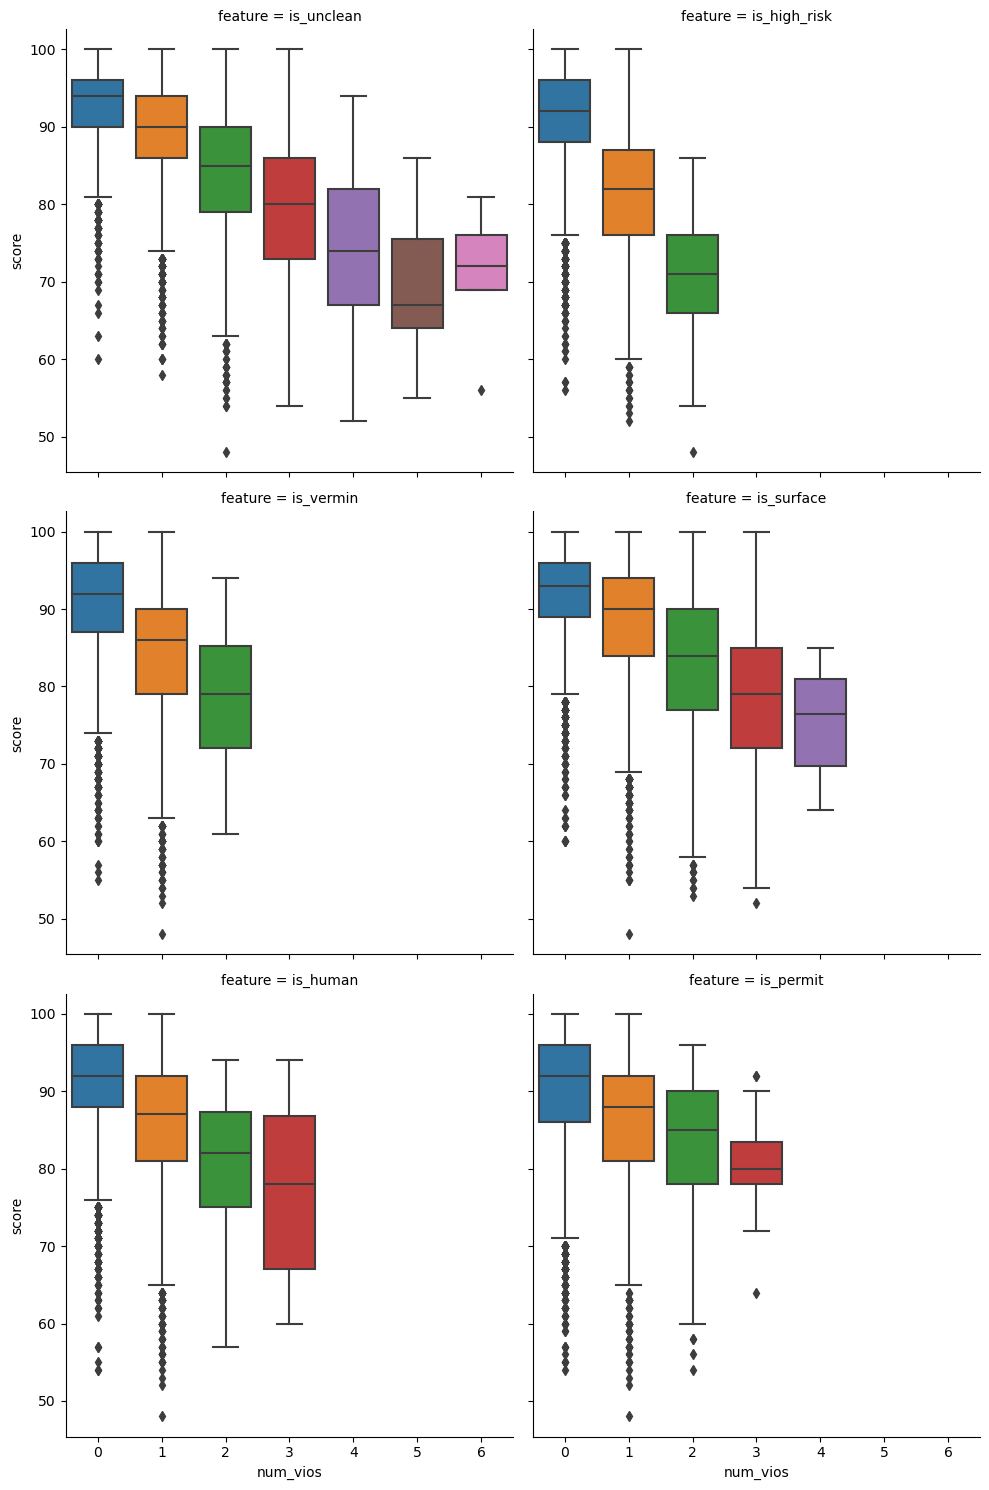

In [68]:
# you will learn this syntax in the next class. Focus on interpreting for now. Use sns.catplot function
import seaborn as sns
sns.catplot(x='num_vios', y='score',
               col='feature', col_wrap=2,
               kind='box',
               data=violation_type_and_scores);